# Natural Language Querying (NLQ)

Using the `.with_natural_query` clause in queries presents the opportunity to describe your query using natural language. The underlying solution (currently using models from OpenAI, local LLM support coming soon) fills the query parameters (weights, filters and other query-time inputs) based on the user's natural language query and runs it.

Here is a by-hand ✍️ illustration of this notebook, created by Prof. Tom Yeh.

[Leave a Star](https://github.com/superlinked/superlinked) to support our open-source effort!

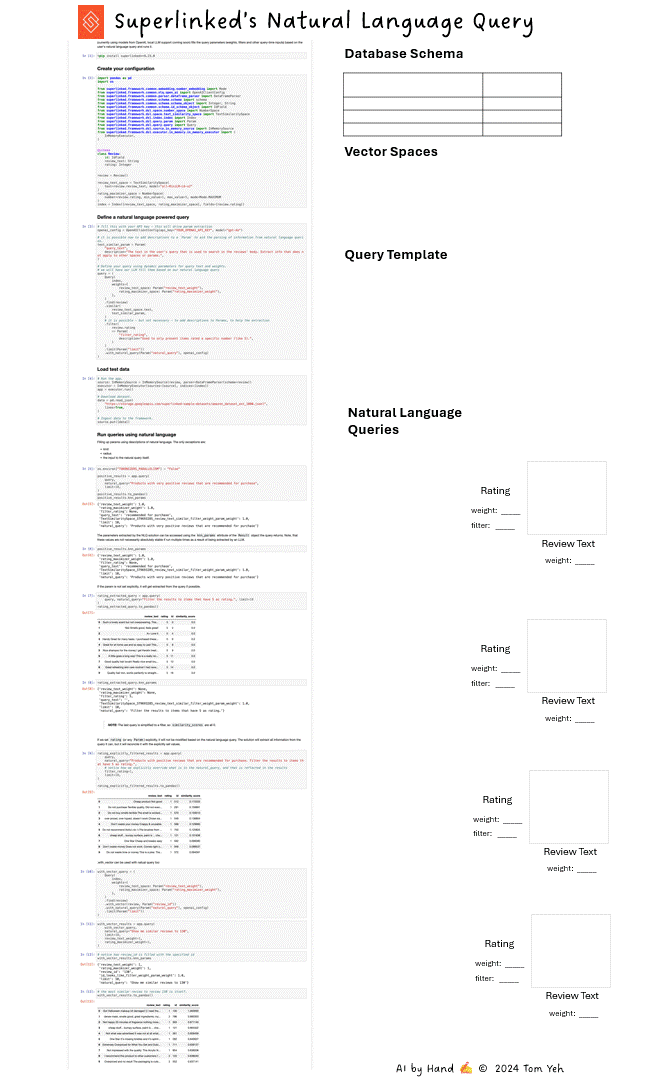

In [ ]:
%pip install superlinked==9.35.0

## Create your configuration

In [ ]:
import os
import pandas as pd

from superlinked.framework.common.embedding.number_embedding import Mode
from superlinked.framework.common.nlq.open_ai import OpenAIClientConfig
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.common.schema.schema import Schema
from superlinked.framework.common.schema.schema_object import Integer, String
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.dsl.space.number_space import NumberSpace
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
)


class Review(Schema):
    id: IdField
    review_text: String
    rating: Integer


review = Review()

review_text_space = TextSimilaritySpace(
    text=review.review_text, model="all-MiniLM-L6-v2"
)
rating_maximizer_space = NumberSpace(
    number=review.rating, min_value=1, max_value=5, mode=Mode.MAXIMUM
)
index = Index([review_text_space, rating_maximizer_space], fields=[review.rating])

## Define a natural language powered query

In [ ]:
# fill this with your API key - this will drive param extraction
openai_config = OpenAIClientConfig(api_key="YOUR_OPENAI_API_KEY", model="gpt-4o")

# it is possible now to add descriptions to a `Param` to aid the parsing of information from natural language queries.
text_similar_param = Param(
    "query_text",
    description=(
        "The text in the user's query that is used to search in the reviews' body."
        " Extract info that does not apply to other spaces or params."
    ),
)

# Define your query using dynamic parameters for query text and weights.
# we will have our LLM fill them based on our natural language query
query = (
    Query(
        index,
        weights={
            review_text_space: Param("review_text_weight"),
            rating_maximizer_space: Param("rating_maximizer_weight"),
        },
    )
    .find(review)
    .similar(
        review_text_space.text,
        text_similar_param,
    )
    # it is possible - but not necessary - to add descriptions to Params, to help the extraction
    .filter(
        review.rating
        == Param(
            "filter_rating",
            description="Used to only present items rated a specific number (like 5).",
        )
    )
    .limit(Param("limit"))
    .with_natural_query(Param("natural_query"), openai_config)
)

## Load test data

In [ ]:
# Run the app.
source: InMemorySource = InMemorySource(review, parser=DataFrameParser(schema=review))
executor = InMemoryExecutor(sources=[source], indices=[index])
app = executor.run()

# Download dataset.
data = pd.read_json(
    "https://storage.googleapis.com/superlinked-sample-datasets/amazon_dataset_ext_1000.jsonl",
    lines=True,
)

# Ingest data to the framework.
source.put([data])

## Run queries using natural language

Filling up params using descriptions of natural language. The only exceptions are:
- limit
- radius
- the input to the natural query itself.

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "False"

positive_results = app.query(
    query,
    natural_query="Products with very positive reviews that are recommended for purchase",
    limit=10,
)
positive_results.to_pandas()
positive_results.knn_params

{'review_text_weight': 1.0,
 'rating_maximizer_weight': 1.0,
 'filter_rating': None,
 'query_text': 'recommended for purchase',
 'TextSimilaritySpace_379693285_review_text_similar_filter_weight_param_weight': 1.0,
 'limit': 10,
 'natural_query': 'Products with very positive reviews that are recommended for purchase'}

The parameters extracted by the NLQ solution can be accessed using the `knn_params` attribute of the `Result` object the query returns. Note, that these values are not necessarily absolutely stable if run multiple times as a result of being extracted by an LLM.

In [ ]:
positive_results.knn_params

{'review_text_weight': 1.0,
 'rating_maximizer_weight': 1.0,
 'filter_rating': None,
 'query_text': 'recommended for purchase',
 'TextSimilaritySpace_379693285_review_text_similar_filter_weight_param_weight': 1.0,
 'limit': 10,
 'natural_query': 'Products with very positive reviews that are recommended for purchase'}

If the param is not set explicitly, it will get extracted from the query if possible.

In [ ]:
rating_extracted_query = app.query(
    query, natural_query="Filter the results to items that have 5 as rating.", limit=10
)
rating_extracted_query.to_pandas()

,review_text,rating,id,similarity_score
0,Such a lovely scent but not overpowering. This...,5,0,0.0
1,"Yes! Smells good, feels great!",5,2,0.0
2,A+ Love it,5,4,0.0
3,Handy Great for many tasks. I purchased these...,5,6,0.0
4,Great for at home use and so easy to use! This...,5,8,0.0
5,Nice shampoo for the money I get Keratin treat...,5,9,0.0
6,A little goes a long way! This is a really nic...,5,11,0.0
7,Good quality hair brush! Really nice small bru...,5,13,0.0
8,Great refreshing skin care routine! I had neve...,5,14,0.0
9,"Quality hair iron, works perfectly to straight...",5,16,0.0


In [ ]:
rating_extracted_query.knn_params

{'review_text_weight': None,
 'rating_maximizer_weight': None,
 'filter_rating': 5,
 'query_text': '',
 'TextSimilaritySpace_379693285_review_text_similar_filter_weight_param_weight': 1.0,
 'limit': 10,
 'natural_query': 'Filter the results to items that have 5 as rating.'}

> **_NOTE:_**  The last query is simplified to a filter, so `similarity_scores` are all 0.

If we set `rating` (or any `Param`) explicitly, it will not be modified based on the natural language query. The solution will extract all information from the query it can, but it will reconcile it with the explicitly set values.

In [ ]:
rating_explicitly_filtered_results = app.query(
    query,
    natural_query=(
        "Products with positive reviews that are recommended for purchase."
        " Filter the results to items that have 5 as rating."
    ),
    # notice how we explicitly override what is in the natural_query, and that is reflected in the results
    filter_rating=1,
    limit=10,
)

rating_explicitly_filtered_results.to_pandas()

,review_text,rating,id,similarity_score
0,Cheap product Not good,1,512,0.172333
1,Do not purchase Terrible quality. Did not even...,1,291,0.159891
2,Do not buy smells terrible The smell is wicked...,1,570,0.150010
3,"over priced, over hyped, doesn't work Chose wa...",1,549,0.136804
4,Don't waste your money Crappy & unusable.,1,588,0.129660
5,Do not recommend Awful.<br />The brushes from ...,1,750,0.125825
6,"cheap stuff... bumpy surface, paint is ... che...",1,121,0.101638
7,One Star Cheap and breaks easy,1,592,0.099390
8,Don't waste money Does not work. Comes right o...,1,948,0.098537
9,Do not waste time or money This is a joke. The...,1,372,0.094591


.with_vector can be used with natural query too

In [ ]:
with_vector_query = (
    Query(
        index,
        weights={
            review_text_space: Param("review_text_weight"),
            rating_maximizer_space: Param("rating_maximizer_weight"),
        },
    )
    .find(review)
    .with_vector(review, Param("review_id"))
    .with_natural_query(Param("natural_query"), openai_config)
    .limit(Param("limit"))
)

In [ ]:
with_vector_results = app.query(
    with_vector_query,
    natural_query="Show me similar reviews to 130",
    limit=10,
    review_text_weight=1,
    rating_maximizer_weight=1,
)

In [ ]:
# notice how review_id is filled with the specified id
with_vector_results.knn_params

{'review_text_weight': 1,
 'rating_maximizer_weight': 1,
 'review_id': '130',
 'id_looks_like_filter_weight_param_weight': 1.0,
 'limit': 10,
 'natural_query': 'Show me similar reviews to 130'}

In [ ]:
# the most similar review to review 130 is itself.
with_vector_results.to_pandas()

,review_text,rating,id,similarity_score
0,Got Halloween makeup kit damaged \] I read the...,1,130,1.000000
1,"dense mask, smells good, great ingredients; my...",2,786,0.685303
2,Not happy 20 minutes of fragrance nothing more...,1,363,0.671140
3,"cheap stuff... bumpy surface, paint is ... che...",1,121,0.664422
4,Not what was advertised It was not at all what...,1,361,0.658459
5,One Star it's missing bristles and it's splint...,1,282,0.640937
6,Extremely Overpriced for What You Get and Dubi...,1,711,0.639137
7,Not impressed with the quality. This Acrylic N...,1,854,0.638208
8,I recommend this product to other customers I'...,2,122,0.638040
9,Overpriced and no result The packaging is cute...,2,552,0.637141
